# Watershed algorithm

In [31]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageEnhance
import ipympl
from skimage.filters import gabor


%matplotlib widget

img = cv2.imread('/home/simenallum/catkin_ws/src/msc_thesis/train_segmentation/test_images_seg/5.PNG')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

In [32]:
# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)

In [33]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

In [34]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

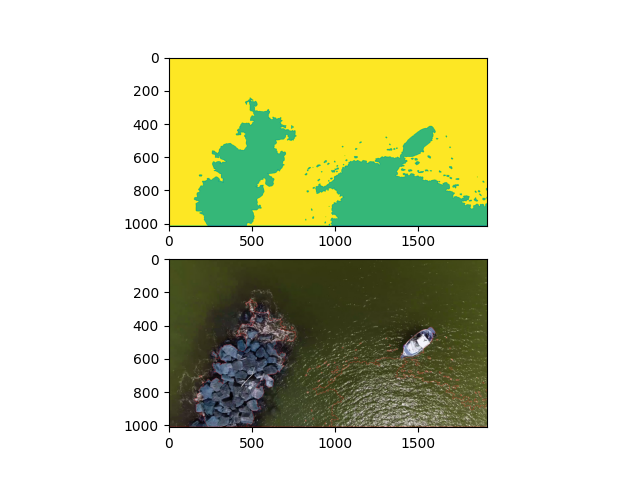

In [35]:
plt.subplot(2,1,1)

plt.imshow(markers)

plt.subplot(2,1,2)

plt.imshow(img)

plt.show()


# EDGE DETECTORS

In [13]:
import numpy as np
from scipy import signal
from PIL import Image
import cv2
import matplotlib.pyplot as plt

def sobel_filter(image):
    # Convert the image to grayscale
    gray_image = Image.fromarray(image).convert('L')
    
    # Define the Sobel filters
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
    
    # Apply the Sobel filters using convolution
    edges_x = signal.convolve2d(gray_image, sobel_x, boundary='symm', mode='same')
    edges_y = signal.convolve2d(gray_image, sobel_y, boundary='symm', mode='same')
    
    # Compute the magnitude of the edges
    edges = np.sqrt(edges_x ** 2 + edges_y ** 2)
    
    # Normalize the edges to the range [0, 255]
    edges = edges / np.max(edges) * 255
    
    # Convert the edges to an unsigned 8-bit integer
    edges = edges.astype(np.uint8)
    
    return edges


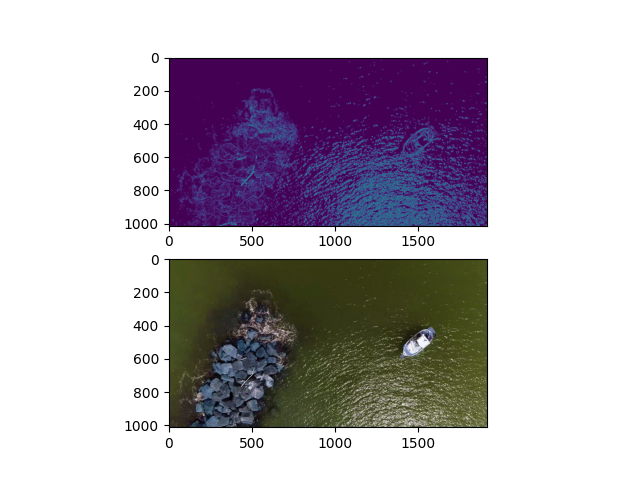

In [14]:
img = cv2.imread('/home/simenallum/catkin_ws/src/msc_thesis/train_segmentation/test_images_seg/5.PNG')

edges = sobel_filter(img)

plt.subplot(2,1,1)
plt.imshow(edges)
plt.subplot(2,1,2)
plt.imshow(img)
plt.show()

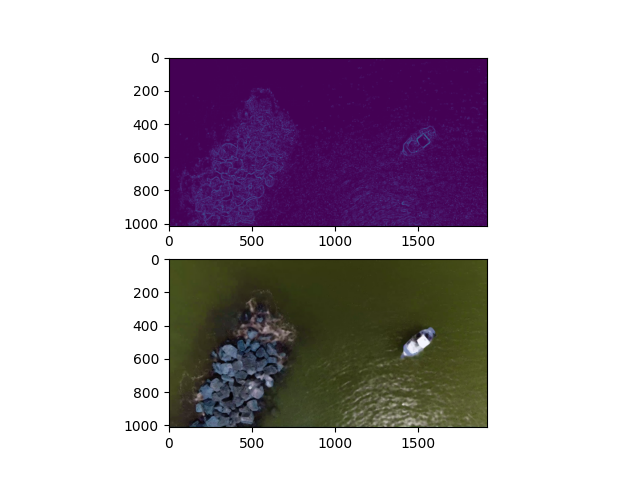

In [15]:

# median blur. This seems to be better than gaussian for bright dots.
blr = cv2.medianBlur(img, 15)
# now grab brightness V of HSV here - but Gray is possibly as good
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
val = hsv[:, :, 2]
# use ADAPTIVE_THRESH_GAUSSIAN to find spots. 
# I manually tweaked the values- these seem to work well with what I have.
at = cv2.adaptiveThreshold(np.array(255 - val), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 17)
# Now invert the threshold, and run another for edges.
ia = np.array(255 - at)  # inversion of adaptiveThreshold of the value.
iv = cv2.adaptiveThreshold(ia, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 5, 6)
# ib = merged edges with the dots (as an invert mask).
ib = cv2.subtract(iv, ia)
# Turn this to a 3 channel mask.
bz = cv2.merge([ib, ib, ib])
# Use the blur where the mask is, otherwise use the image.
dsy = np.where(bz == (0, 0, 0), blr, img)
result = dsy


edges = sobel_filter(result)

plt.subplot(2,1,1)
plt.imshow(edges)
plt.subplot(2,1,2)
plt.imshow(result)
plt.show()

In [70]:
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import gaussian, sobel
from skimage.segmentation import active_contour

def segment_land_sea(image):
    # Convert the image to grayscale
    image_gray = rgb2gray(image)
    
    # Apply Gaussian smoothing and Sobel edge detection
    smoothed = gaussian(image_gray, sigma=2)
    edges = sobel(smoothed)
    
    return edges, smoothed



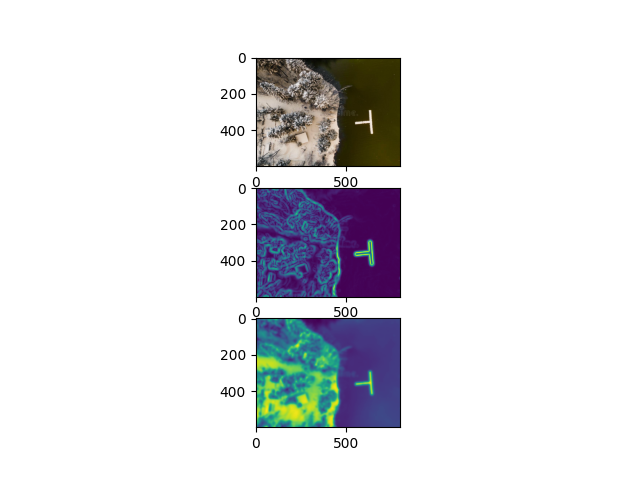

In [74]:
img = cv2.imread('/home/simenallum/catkin_ws/src/msc_thesis/train_segmentation/test_images_seg/ice.jpg')

edges, smoothed = segment_land_sea(img)

plt.figure()
plt.subplot(3,1,1)
plt.imshow(img)
plt.subplot(3,1,2)
plt.imshow(edges)
plt.subplot(3,1,3)
plt.imshow(smoothed)
plt.show()

In [128]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_thresholding(arr, threshold=0.5):
    return np.where(arr > threshold, 1, 0)


In [250]:
import cv2
import numpy as np

def find_longest_path(binary_image):
    # Find the boundary pixels of the image
    contours, hierarchy = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boundary_pixels = np.concatenate(contours)

    boundary_pixels = np.squeeze(boundary_pixels)
    
    longest_path = []
    max_path_length = 0
    
    # For each boundary pixel, find the longest path to the opposite border
    for start_pixel in boundary_pixels:
        path = [start_pixel]
        stack = [path]
        
        while len(stack) > 0:
            current_path = stack.pop()
            current_pixel = current_path[-1]
            
            # Check if the current path reaches the opposite border
            if is_on_opposite_border(current_pixel, binary_image.shape):
                # Update the longest path if the current path is longer
                if len(current_path) > max_path_length:
                    longest_path = current_path
                    max_path_length = len(current_path)
            else:
                # Add the neighbors of the current pixel to the stack
                neighbors = get_neighbors(current_pixel, binary_image)
                for neighbor in neighbors:
                    if is_point_not_in_array(neighbor,current_path):
                        stack.append(current_path + [neighbor])
    
    
    print(max_path_length)
    return longest_path

def is_on_opposite_border(pixel, image_shape):
    # Check if the pixel is on the opposite border from the starting border
    val = (pixel[0] == 0 or pixel[0] == image_shape[0]-1) or (pixel[1] == 0 or pixel[1] == image_shape[1]-1)
    return val

def is_point_not_in_array(point, array):
    not_in_array = True
    for row in array:
        if np.array_equal(row, point):
            not_in_array = False
            break

    return not_in_array

def get_neighbors(pixel, image):
    # Get the 8-connected neighbors of a pixel in an image
    neighbors = []
    for i in range(pixel[0]-1, pixel[0]+2):
        for j in range(pixel[1]-1, pixel[1]+2):
            if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                if image[i][j] == 255:
                    neighbors.append((i,j))
    return neighbors


In [251]:
import cv2
import numpy as np

# Load the image
img = cv2.imread('/home/simenallum/catkin_ws/src/msc_thesis/train_segmentation/test_images_seg/ice.jpg')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Gaussian smoothing to the image
blur = cv2.GaussianBlur(gray, (5, 5), 10)

# Apply Canny edge detection to the image
edges = cv2.Canny(blur, 50, 150, apertureSize=3)

res = find_longest_path(edges)

# Display the image
plt.figure()
plt.imshow(edges)
plt.show()

KeyboardInterrupt: 